TP- Recalage d'images
=============

In [1]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g,im1,im2

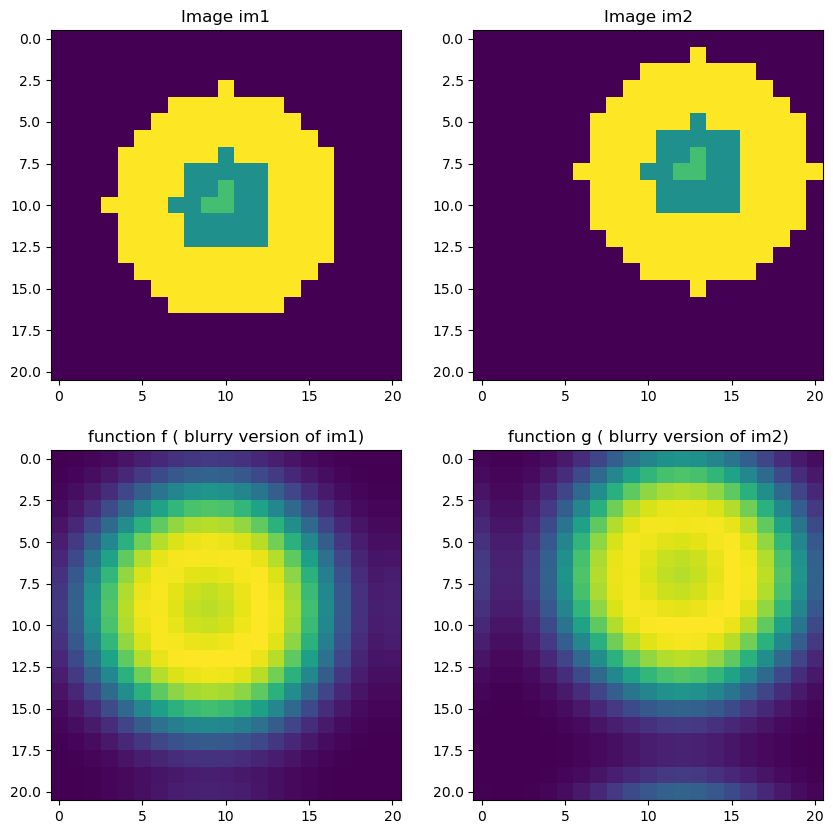

In [3]:
f,g,im1,im2=get_images()
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr[0,0].imshow(im1)
axarr[0,0].set_title('Image im1')
axarr[1,0].imshow(f)
axarr[1,0].set_title('function f ( blurry version of im1)')
axarr[0,1].imshow(im2)
axarr[0,1].set_title('Image im2')
axarr[1,1].imshow(g)
axarr[1,1].set_title('function g ( blurry version of im2)')
plt.show()

# 1. Formalisation du problème
## 1.1 Formalisme continu

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;margin:5px">
Problème $(P_1)$ : <br>
Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$
</div>

Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution. Si $f$ est la constante $1$ et si $g$ est la constante $0$, il n'existe pas de solutions.

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;margin:5px">
Problème $(P_2)$ : <br>
On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$
</div>

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du flou (on dit aussi du "bruit") par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations  de  volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;margin:5px">
$$(P)\qquad \min_{u} E(u)+R(u).$$
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations  de  volume}}.
$$    
</div>

**Q1.** A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$dE(u)\cdot h= \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

Puis par définition, on a $$ dE(u)\cdot h =\langle \nabla E(u),h\rangle \quad \forall h$$
<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Réponse:

D'après le développement de Taylor, on sait que:

$$ f(x+u(x)+h(x))=f(x+u(x))+\langle \nabla f(x+u(x)),h(x)\rangle +o(\| h \|)$$

Donc on a :
$$\begin{align}
E(u+h) &= \displaystyle\frac{1}{2}\int_\Omega (f(x+u(x)+h(x))-g(x))^2 dx \\
&= \displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))+\langle \nabla f(x+u(x)),h(x)\rangle +o(\| h \|)-g(x))^2 dx\\
&= \displaystyle\frac{1}{2}\int_\Omega [f(x+u(x))-g(x)]^2 +2 \langle \nabla f(x+u(x)), h(x) \rangle ( f(x+u(x)) - g(x) ) + o(\|h\|) ) dx \\
&= E(u) + \int_{\Omega} \langle \left( f(x + u(x)) - g(x) \right) \nabla f(x + u(x)), h(x) \rangle dx + o(\|h\|)
\end{align}$$
Par suite comme:
$$ E(u+h)=E(u)+\langle \nabla E(u),h\rangle +o(\| h \|)\\$$
Donc par identification, on a que:
$$\nabla E(u)=\left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$


</div>

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathcal M_{n,m}(\mathbb{R})$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$

## 2.1. Calcul du $E$ et de son gradient
Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. Pour cela, vous aurez besoin de la fonction `interpol` ci-dessous.

In [4]:
def interpol(function,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),function)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

**Q2.** Lisez la documentation de la fonction `RectBivariateSpline` afin de comprendre ce que fait la fonction `interpol`.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
La fonction interpol prend une matrice 2D (comme une image) et des matrices de déplacement, et produit une nouvelle matrice 2D où la valeur à chaque point est interpolée à partir de la matrice originale en utilisant les déplacements spécifiés.
 RectBivariateSpline de la bibliothèque SciPy est une classe pour l'interpolation bidimensionnelle de données sur une grille rectangulaire.
</div>


## 2.2. Calcul de $R$ et de son gradient
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par, pour tout $f\in V$ par
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases}.$$
On a ainsi $\partial_x f\in V$.

On définit les opérateurs $\partial_x^T$ et $\partial_y^T$ comme les uniques opérateurs qui vérifient

$$ \langle \partial_x^T f, g\rangle_V = \langle f,\partial_x  g\rangle_V \quad \forall f,g\in V$$
$$ \langle \partial_y^T f, g\rangle_V = \langle f,\partial_y  g\rangle_V \quad \forall f,g\in V$$

**Q2.** Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après. On donne un test de vérification.

On sait que : 

$$ \langle \partial _x ^T u, v \rangle = \langle  u, \partial _x v \rangle $$
donc :
$$\begin{align}
\langle \partial _x ^T u, v \rangle &=\sum_{i=1}^{n}\sum_{j=1}^{m}(\partial _x ^T u)_{i,j}.v_{ij}\\
&=\sum_{i=1}^{n}\sum_{j=1}^{m} u_{i,j}.(\partial _x v)_{ij}\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}(v_{i+1,j}-v_{ij})\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}v_{i+1,j}-\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}v_{ij}\\
&=\sum_{i=2}^{n}\sum_{j=1}^{m}u_{i-1,j}v_{ij}-\sum_{i=1}^{n-1}\sum_{j=1}^{m}u_{ij}v_{ij}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{m}u_{i-1,j}v_{ij}-\sum_{i=2}^{n-1}\sum_{j=1}^{m}u_{ij}v_{ij} - \sum_{j=1}^{m} u_{1j}v_{1j} + \sum_{j=1}^{m} u_{n-1,j}v_{nj}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{m}(u_{i-1,j}-u_{ij})v_{i,j} + \sum_{j=1}^{m} u_{n-1,j}v_{n,j}-\sum_{j=1}^{m}u_{1j}v_{1j}\\ \\ \\
\end{align}$$

Par identification, on a que:
$$\partial _x ^T u=\begin{cases}u_{i-1,j}-u_{ij} \text{ si } i\geq 2  \text{ et } i \leq n-1 \\
        u_{n-1,j} \text{ si } i=n \\
        -u_{1,j} \text{ si } i=1 \end{cases} $$

De plus,
$$\partial _y ^T u=\begin{cases}u_{i,j-1}-u_{ij} \text{ si } j\geq 2  \text{ et } j \leq m-1 \\
        u_{i,m-1} \text{ si } j=m \\
        -u_{i,1} \text{ si } j=1 \end{cases} $$


In [5]:
def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,1:-1]=im[:,0:-2]-im[:,1:-1]
    d[:,-1]=im[:,-2]
    d[:,0]=-im[:,0]
    return d  
def dxT(im) :
    d=np.zeros(im.shape)
    d[1:-1,:]=im[0:-2,:]-im[1:-1,:]
    d[-1,:]=im[-2,:]
    d[0,:]=-im[0,:]
    return d

def scal(a,b) :
    return np.sum(a*b)

np.random.seed(42)
im1=np.random.randn(12,15)
im2=np.random.randn(12,15)
print(scal(dx(im1),im2),'=',scal(im1,dxT(im2)))

-17.489408391382973 = -17.489408391382973


**Q3.**  On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\underbrace{\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i)}_{=R_1(u)} + \frac{\lambda+\mu}{2} \underbrace{\sum_i(\partial_x u_x + \partial_y u_y)^2(i)}_{=R_2(u)}.
$$ 
où:
* $u_x\in V$ et $u_y\in V$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie
* $\partial_x:V \rightarrow V$ et $\partial_y:V\rightarrow V$ représentent les opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{\mu}{2}R_1(u)+ \frac{\lambda+\mu}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle_V,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle_V.
$$
Où $A_i$ est un opérateur de $V^2$ dans $V$.
Donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$ et $\partial_y$.


<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On sait que:
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
De plus,
$$R(u) = \frac{1}{2} R_1(u) + \frac{1}{2} R_2(u) = \frac{1}{2} \langle A_1u,A_1u \rangle + \frac{1}{2} \langle A_2u,A_2u \rangle$$

Donc à partir de $R(u)$,on pourra retrouver l'expression de $A_{1}$ et $A_{2}$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

Pour $A_{1}$:
$$R_{1}(u)= \|A_1u\|^2 = \left\|A_1 \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\right\|^2 = \mu \|\partial_x u_y + \partial_y u_x \|^2=\mu \|\left( \partial_y \text{ } \partial_x \right)\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\|^2$$
Donc, $$A_1 = \sqrt{\mu} \left( \partial_y \text{ } \partial_x \right)$$

Pour $A_{2}$:
$$R_{2}(u)= \|A_2u\|^2 = \left\|A_2 \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\right\|^2 = (\lambda+\mu) \|\partial_x u_x + \partial_y u_y \|^2=(\lambda+\mu) \|\left( \partial_x \text{ } \partial_y \right)\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\|^2$$
Donc, $$A_2 = \sqrt{\lambda+\mu} \left( \partial_x \text{ } \partial_y \right)$$
</div>


**Q3b.**
Pour tout $u=(u_x,u_y)$ et $v=(v_x,v_y)$ dans $V^2$, on définit le produit scalaire dans $V^2$ par
$$\langle u,v\rangle_{V^2}=\langle u_x,v_x\rangle_{V}+\langle u_y,v_y\rangle_{V}$$

Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$

Avec $$A=\mu A_1^TA_1 +(\lambda+\mu) A_2^TA_2$$ et $A_i^T$ un opérateur de $V^2$ dans $V$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Votre réponse ici
</div>

**Q4.** Donner l'expression du gradient de $R$.
<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On sait que :
$R(u) = \frac{1}{2} R_1(u) + \frac{1}{2} R_2(u)$, on a $\nabla R(u) = \frac{1}{2} \nabla R_1(u) + \frac{1}{2} \nabla R_2(u)$.

Donc , on calcule de façon séparée $\nabla R_1$ et $\nabla R_2$ :

Pour $\nabla R_1(u)$ : 

$$\begin{align}
\nabla R_1(u) &= 2 A_1^T A_1 u \\
&= 2\mu \left(\begin{array}{c}
\partial_y^T\\
\partial_x^T
\end{array}\right) (\partial_y \text{ } \partial_x) \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2\mu \begin{pmatrix}\partial_y^T\partial_y & \partial_y^T\partial_x \\ \partial_x^T\partial_y & \partial_x^T\partial_x \end{pmatrix} \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2\mu \left(\begin{array}{c}\partial_y^T\partial_yu_x + \partial_y^T\partial_xu_y\\ \partial_x^T\partial_yu_x +  \partial_x^T\partial_xu_y\end{array}\right)
\end{align}$$

Pour $\nabla R_2(u)$ :

$$\begin{align}
\nabla R_2(u) &= 2 A_2^T A_2 u \\
&= 2(\lambda +\mu) \left(\begin{array}{c}
\partial_x^T\\
\partial_y^T
\end{array}\right) (\partial_x \text{ } \partial_y) \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2(\lambda +\mu) \begin{pmatrix}\partial_x^T\partial_x & \partial_x^T\partial_y \\ \partial_y^T\partial_x & \partial_y^T\partial_y \end{pmatrix} \left(\begin{array}{c}
u_x\\
u_y
\end{array}\right) \\
&= 2(\lambda +\mu) \left(\begin{array}{c}\partial_x^T\partial_x u_x + \partial_x^T\partial_y u_y\\ \partial_y^T\partial_x u_x +  \partial_y^T\partial_y u_y\end{array}\right)
\end{align}$$

Par suite, on retrouve donc: 
$$ \nabla R(u) = \frac{1}{2} \nabla R_1(u) + \frac{1}{2} \nabla R_2(u) = \mu \left(\begin{array}{c}\partial_y^T\partial_yu_x + \partial_y^T\partial_xu_y\\ \partial_x^T\partial_yu_x +  \partial_x^T\partial_xu_y\end{array}\right) + (\lambda +\mu) \left(\begin{array}{c}\partial_x^T\partial_x u_x + \partial_x^T\partial_y u_y\\ \partial_y^T\partial_x u_x +  \partial_y^T\partial_y u_y\end{array}\right)
$$


</div>

## 2.3. Implémentation de la fonction objectif $E+R$

Créez une fonction `objective_function` qui calcul $E(u)+R(u)$. 

Cette fonction prend en variable d'entrée 
* `f`,`g` et `ux` et `uy` qui sont nécessaires au calcul de $E(u)$
* `ux`,`uy` ,`lamb` et `mu` qui sont nécessaires au calcul de $R(u)$. Ici `lamb` et `mu` sont deux variables réelles positives qui représentent $\lambda$ et $\mu$. 


Cette fonction doit rendre deux arguments :
* `obj` qui est la valeur de $E(u)+R(u)$
* `fu` qui est un tableau qui représente le résultat du calcul de $f\circ(Id +u)$. On rend ce tableau car il sera utile pour les prochains calculs.

In [6]:
def objective_function(f,g,ux,uy,lamb,mu) :
    fu=interpol(f,ux,uy)
    #calcul de E
    E=(1/2)*np.linalg.norm(fu-g)**2
    R=(mu/2)*np.linalg.norm(dx(uy)+dy(ux))**2+((lamb+mu)/2)*np.linalg.norm(dx(ux)+dy(uy))**2
    obj=E+R
    return obj,fu
np.random.seed(12)
ux=np.random.randn(f.shape[0],f.shape[1])
uy=np.random.randn(f.shape[0],f.shape[1])
obj,fu=objective_function(2*f,3*g,ux,uy,10,5)
print(obj,fu.shape,np.linalg.norm(fu)) #18215.406074781582 (21, 21) 22.047265562734097

18215.406074781582 (21, 21) 22.047265562734097


## 2.4 Implémentation des gradients
Créez une fonction `gradE` et `gradR` qui calcule $\nabla E(u)$ et $\nabla R(u)$. On garde les conventions de noms de variable de la section précédente et on notera `gradxE,gradyE` les deux composantes de  $\nabla E(u)$ et `gradxR,gradyR` les deux composantes de $\nabla R(u)$. Les variables `dfx` et `dfy`contiennent les dérivées selon `x` et `y` de `f`, elles seront initalisées par `dfx=dx(f)` et `dfy=dy(f)`

In [7]:
def gradE(dfx,dfy,g,fu,ux,uy) :
    gradxE=(fu-g)*interpol(dfx,ux,uy)
    gradyE=(fu-g)*interpol(dfy,ux,uy)
    return gradxE,gradyE

def gradR(lamb,mu,ux,uy) :
    gradxR=mu*(dyT(dy(ux))+dyT(dx(uy)))+(lamb+mu)*(dxT(dx(ux))+dxT(dy(uy)))
    gradyR=mu*(dxT(dy(ux))+dxT(dx(uy)))+(lamb+mu)*(dyT(dx(ux))+dyT(dy(uy)))
    return gradxR,gradyR

In [8]:
dfx=dx(f)
dfy=dy(f)  
np.random.seed(12)
ux=np.random.randn(f.shape[0],f.shape[1])
uy=np.random.randn(f.shape[0],f.shape[1])
obj,fu=objective_function(f,g,ux,uy,10,5)
gradxE,gradyE=gradE(dfx,dfy,g,fu,ux,uy)
print(gradxE.shape,gradyE.shape) #(21, 21) (21, 21)
print(np.linalg.norm(gradxE),np.linalg.norm(gradyE)) #0.6513993385167333 0.6040320505869908
gradxR,gradyR=gradR(10.,5.,ux,uy) 
print(gradxR.shape,gradyR.shape)  #(21, 21) (21, 21)
print(np.linalg.norm(gradxR),np.linalg.norm(gradyR)) #1180.7792368512296 1239.1880693357143

(21, 21) (21, 21)
0.6513993385167333 0.6040320505869908
(21, 21) (21, 21)
1180.7792368512296 1239.1880693357143


# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

**Q5.** Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [9]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step


def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   
        # Gradient of E at point u
        gradEx=gradE(dfx,dfy,g,fu,ux,uy)[0]
        gradEy=gradE(dfx,dfy,g,fu,ux,uy)[1]
        
        
        # Gradient of R at point u
        gradRx=gradR(lamb,mu,ux,uy)[0]
        gradRy=gradR(lamb,mu,ux,uy)[1]
        
        
        # Gradient of E+R at point u
        gradx=gradEx+gradRx
        grady=gradEy+gradRy
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list)

**Q5.** Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [11]:
lamb=10
mu=20
nitermax=500

step0 = 0.01
ux,uy,CF,step=RecalageDG(f,g,lamb,mu,nitermax,step0)
# la premiere ligne est 
# iteration : 3  cost function : 19.08125492560699 step : 0.08

iteration : 3  cost function : 19.08125492560699 step : 0.08
iteration : 6  cost function : 19.042743727061186 step : 0.02
iteration : 9  cost function : 19.031367910404178 step : 0.01
iteration : 12  cost function : 19.0241238388873 step : 0.01
iteration : 15  cost function : 19.018062108808994 step : 0.01
iteration : 18  cost function : 19.012534592575683 step : 0.005
iteration : 21  cost function : 19.008553844119767 step : 0.005
iteration : 24  cost function : 19.00309484901698 step : 0.005
iteration : 27  cost function : 18.998331455402845 step : 0.005
iteration : 30  cost function : 18.99381720889842 step : 0.005
iteration : 33  cost function : 18.98942613969346 step : 0.005
iteration : 36  cost function : 18.985108875828217 step : 0.01
iteration : 39  cost function : 18.9819338005628 step : 0.005
iteration : 42  cost function : 18.977325922450245 step : 0.005
iteration : 45  cost function : 18.972843826708218 step : 0.005
iteration : 48  cost function : 18.968449166600784 step :

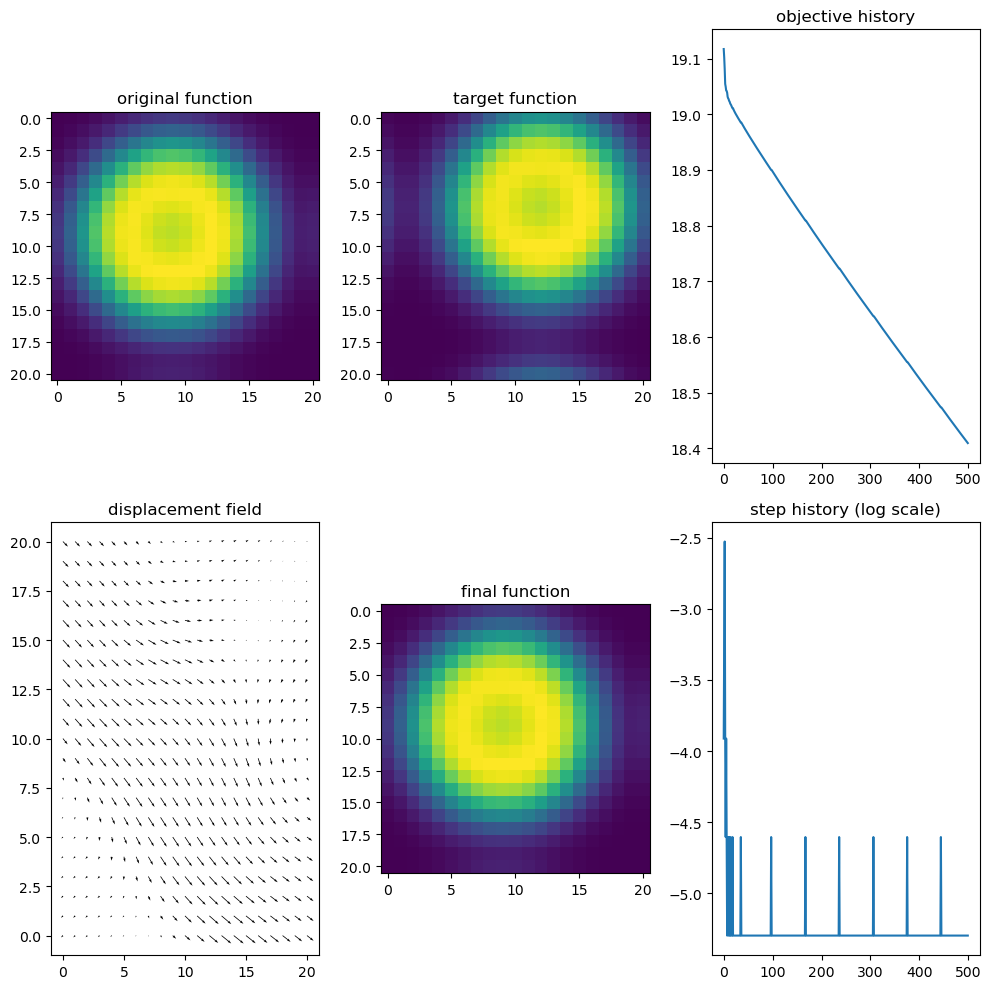

In [12]:
fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $$(P)\quad\min_u E(u)+R(u)$$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

**Q6.** Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.
<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On sait que:
$$J_{\psi}(u)=\begin{pmatrix} 
\nabla _{\psi_1}(u)^T \\ 
\nabla _{\psi_2}(u)^T \\
\nabla _{\psi_3}(u)^T \
 \end{pmatrix}$$
 
 De plus, $${\psi}(u)=\begin{pmatrix} 
{\psi_1}(u) \\ 
{\psi_2}(u) \\
{\psi_3}(u) \\
 \end{pmatrix}$$ 
 et 
$${\psi}(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix}$$

Afin de déterminer $J_{\psi}(u)$ , on calcule les différentes valeurs $\nabla _{\psi_1}$ ,$\nabla _{\psi_2}$,$\nabla _{\psi_3}$ :

$$\begin{align}
\nabla _{\psi_2}(u)&=\sqrt{\mu} \nabla(\partial _x u_y + \partial _y u_x)\\
&=\sqrt{\mu}  \nabla \begin{pmatrix} 
\partial _y  \\
\partial _x  \\
\end{pmatrix}
\begin{pmatrix} 
u _x  \\
u _y  \\
\end{pmatrix}
\end{align}$$
Donc , par suite , on a bien que :
$$\begin{align}
\nabla _{\psi_2}&=\sqrt{\mu} \begin{pmatrix} 
\partial _y  \\
\partial _x  \\
\end{pmatrix}
\end{align}$$

Calculons ensuite $\nabla _{\psi_3}$ :
$$\begin{align}
\nabla _{\psi_3}(u)&=\sqrt{\mu+\lambda}  \nabla(\partial _x u_x + \partial _y u_y)\\
&=\sqrt{\mu+\lambda}\nabla \begin{pmatrix} 
\partial _x  \\
\partial _y  \\
\end{pmatrix}
\begin{pmatrix} 
u _x  \\
u _y  \\
\end{pmatrix}
\end{align}$$
Donc par suite , on a bien que :
$$\begin{align}
\nabla _{\psi_3}&=\sqrt{\mu+\lambda} \begin{pmatrix} 
\partial _x \\
\partial _y  \\
\end{pmatrix}
\end{align}$$
Enfin , on calculera $\nabla _{\psi_1}$ :
on sait que $(J_{\psi_1}(u))^T$=$\nabla _{\psi_1}(u)$ et $J_{Id+u}(u)=\nabla^T(Id+u)(u)=Id$

$$\begin{align}
J_{\psi_1}(u)&=J_f(Id+u) \times J_{Id+u}(u) \\
&=\nabla^Tf(Id+u) \times Id \\
&=\nabla^Tf(Id+u)  
\end{align}$$

On obtient donc:
$$\begin{align}
J_{\psi}(u) = \begin{pmatrix}
df_x(Id+u) & df_y(Id+u) \\
\sqrt{\mu}\partial _y & \sqrt{\mu}\partial _x  \\
\sqrt{\lambda + \mu}\partial _x & \sqrt{\lambda +\mu}\partial _y \\
\end{pmatrix}
\end{align}$$

</div>

**Q7.** Implémenter les fonctions `Psi`,`JPsi`, `JTPsi` et `JTJ` qui calculent respectivement:
- La valeur de $\Psi(u)$
- le produit de $J_\Psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.


Par convention `fu` représente $f\circ(Id+u)$ et `dfxu`et `dfyu` représentent les deux coordonnées de $(\nabla f)\circ(Id +u)$. On vous donne dans la cellulle suivante des tests de vérification.

In [13]:
def Psi(fu,g,ux,uy,lamb,mu) :
    Psi0=fu-g
    Psi1=np.sqrt(mu)*dy(ux)+np.sqrt(mu)*dx(uy)
    Psi2=np.sqrt(lamb+mu)*dx(ux)+np.sqrt(lamb+mu)*dy(uy)
    return Psi0,Psi1,Psi2

def JPsi(vx,vy,dfxu,dfyu,lamb,mu) :
    JPsi0=dfxu*vx+dfyu*vy
    JPsi1=np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2=np.sqrt(mu+lamb)*dx(vx)+np.sqrt(mu+lamb)*dy(vy)
    return JPsi0,JPsi1,JPsi2

def JTPsi(phi,dfxu,dfyu,lamb,mu) :
    ux=phi[0]*dfxu+np.sqrt(mu)*dyT(phi[1])+np.sqrt(lamb+mu)*dxT(phi[2])
    uy=phi[0]*dfyu+np.sqrt(mu)*dxT(phi[1])+np.sqrt(lamb+mu)*dyT(phi[2])
    return ux,uy
  
def JTJ(vx,vy,dfxu,dfyu,lamb,mu,epsilon) :
    uxs,uys=JTPsi(JPsi(vx,vy,dfxu,dfyu,lamb,mu),dfxu,dfyu,lamb,mu)
    uxs=uxs+epsilon*vx
    uys=uys+epsilon*vy 
    return uxs,uys

In [14]:
n=50
np.random.seed(42)
fu=np.random.randn(n,n)
tmp_g=np.random.randn(n,n)
ux=np.random.randn(n,n)
uy=np.random.randn(n,n)
dfxu=np.random.randn(n,n)
dfyu=np.random.randn(n,n)
print('## TESTING PSI')
Psi0,Psi1,Psi2=Psi(fu,tmp_g,ux,uy,5,10)
print(Psi0.shape,Psi1.shape,Psi2.shape) #(50, 50) (50, 50) (50, 50)
print(np.linalg.norm(Psi0),np.linalg.norm(Psi1),np.linalg.norm(Psi2)) # 70.85046394690714 320.74675708932546 389.63146864883447
print('## TESTING JPSI')
Psi0,Psi1,Psi2=JPsi(ux,uy,dfxu,dfyu,5,10)
print(Psi0.shape,Psi1.shape,Psi2.shape) # (50, 50) (50, 50) (50, 50)
print(np.linalg.norm(Psi0),np.linalg.norm(Psi1),np.linalg.norm(Psi2)) #69.27576209907774 320.74675708932546 389.63146864883447
print('## TESTING JTPSI')
Psi0=np.random.randn(n,n)
Psi1=np.random.randn(n,n)
Psi2=np.random.randn(n,n)
vx,vy=JTPsi((Psi0,Psi1,Psi2),dfxu,dfyu,5,10)
print(vx.shape,vy.shape) # (50, 50) (50, 50)
print(np.linalg.norm(vx),np.linalg.norm(vy)) #355.08391793335545 352.46941362403214
print('## TESTING JTJ')
vx,vy=JTJ(ux,uy,dfxu,dfyu,5.,10.,1.)
print(vx.shape,vy.shape) # (50, 50) (50, 50)
print(np.linalg.norm(vx),np.linalg.norm(vy)) #3571.889912528785 3522.237528300008


## TESTING PSI
(50, 50) (50, 50) (50, 50)
70.85046394690714 320.74675708932546 389.63146864883436
## TESTING JPSI
(50, 50) (50, 50) (50, 50)
69.27576209907774 320.74675708932546 389.63146864883436
## TESTING JTPSI
(50, 50) (50, 50)
355.0839179333555 352.46941362403214
## TESTING JTJ
(50, 50) (50, 50)
3571.889912528785 3522.2375283000083


Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [15]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,dfxu,dfyu) :
    nitmax=100
    ux,uy=u0x,u0y #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,dfxu,dfyu,lamb,mu,epsilon)
    rx=b[0]-Ax
    ry=b[1]-Ay
    px,py=np.copy(rx),np.copy(ry)
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,dfxu,dfyu,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return ux,uy

**Q8.** Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [16]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape) 
    dfx=dx(f)
    dfy=dy(f)
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        dfxu=interpol(dfx,ux,uy)
        dfyu=interpol(dfy,ux,uy)
        b=JTPsi(Psi(fu,g,ux,uy,mu,lamb),dfxu,dfyu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfxu,dfyu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list)

**Q9.** Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [17]:
epsi=0.1
nitermax=1000
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)
# On doit trouver comme première ligne
#iteration : 3  cost function : 18.9861786936971 step : 0.08

iteration : 3  cost function : 18.98617869369697 step : 0.08
iteration : 6  cost function : 17.82272572907551 step : 0.64
iteration : 9  cost function : 10.583907439691627 step : 5.12
iteration : 12  cost function : 1.4813608320994938 step : 1.28
iteration : 15  cost function : 0.8106834451167242 step : 1.28
iteration : 18  cost function : 0.518688781893194 step : 2.56
iteration : 21  cost function : 0.38065348802082566 step : 2.56
iteration : 24  cost function : 0.3147560195991347 step : 2.56
iteration : 27  cost function : 0.2818675400811149 step : 2.56
iteration : 30  cost function : 0.2656698729515861 step : 2.56
iteration : 33  cost function : 0.2573951471170326 step : 2.56
iteration : 36  cost function : 0.2533354890061662 step : 2.56
iteration : 39  cost function : 0.251296358818514 step : 2.56
iteration : 42  cost function : 0.25036501512477183 step : 2.56
iteration : 45  cost function : 0.24994821970252204 step : 2.56
iteration : 48  cost function : 0.24980827813277623 step : 

On remarque que l'algorithme des moindres carrés converge plus rapidement comparant à l'algorithme de descente de gradient. En effet ,le nombre d'itérations de l'algorithme des moindres carrés est égale à 48 qui est très inférieure au nombre d'itérations de l'algorithme de descente de gradient.

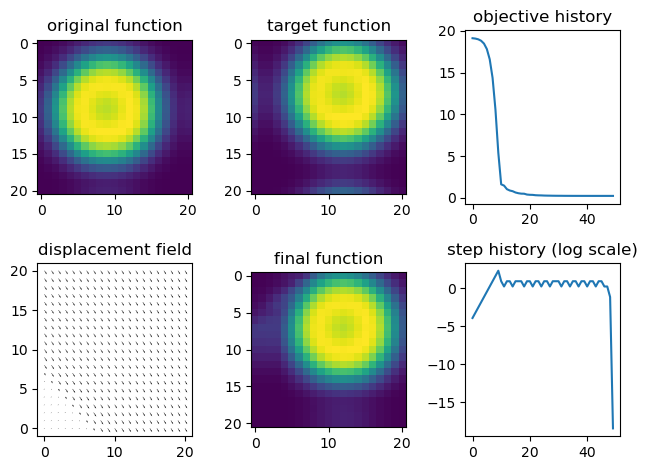

In [18]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

# 5. Jeu des différences
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

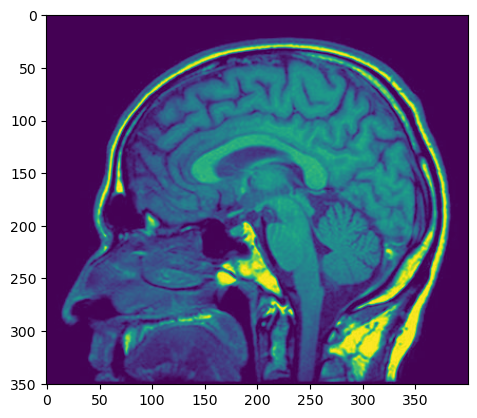

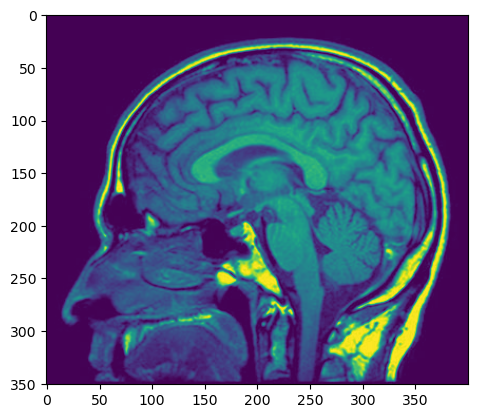

In [19]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [20]:
[n,m]=im1.size
sigma=0.2
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

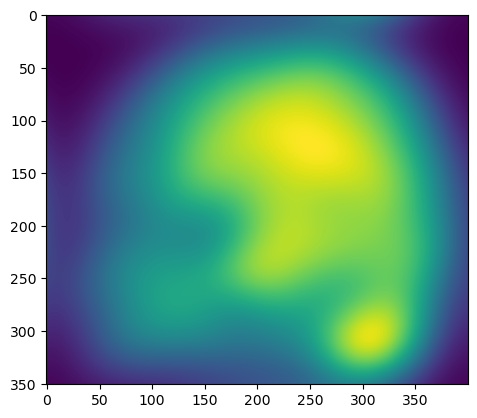

In [21]:
plt.imshow(f)

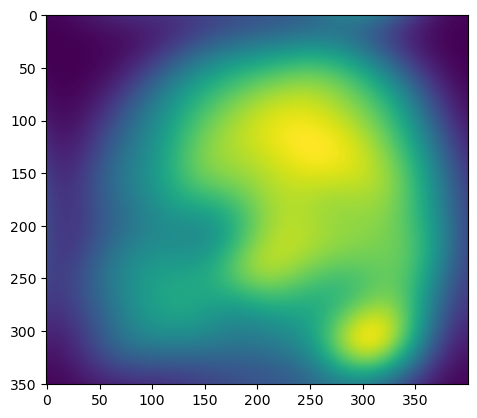

In [22]:
plt.imshow(g)

In [23]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [24]:
[n,m]=im1.size
sigma=0.01
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [25]:
epsi=0.01
step0=0.01
nitermax=500
lamb=0.0001
mu=0.0001
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 2.6839462465073978 step : 0.08
iteration : 6  cost function : 2.0284033105056767 step : 0.64
iteration : 9  cost function : 0.4869730160177394 step : 5.12
iteration : 12  cost function : 0.14085249407064304 step : 2.56
iteration : 15  cost function : 0.11114494221439977 step : 2.56
iteration : 18  cost function : 0.09599077292026556 step : 2.56
iteration : 21  cost function : 0.08524067632652496 step : 1.28
iteration : 24  cost function : 0.07494773124600218 step : 2.56
iteration : 27  cost function : 0.06839865099956086 step : 5.12
iteration : 30  cost function : 0.06304705330287422 step : 2.56
iteration : 33  cost function : 0.05992059326327939 step : 2.56
iteration : 36  cost function : 0.05680617009055569 step : 2.56
iteration : 39  cost function : 0.05453130160712284 step : 2.56
iteration : 42  cost function : 0.05219698175710828 step : 2.56
iteration : 45  cost function : 0.0504764877290117 step : 2.56
iteration : 48  cost function : 0.0486220421717

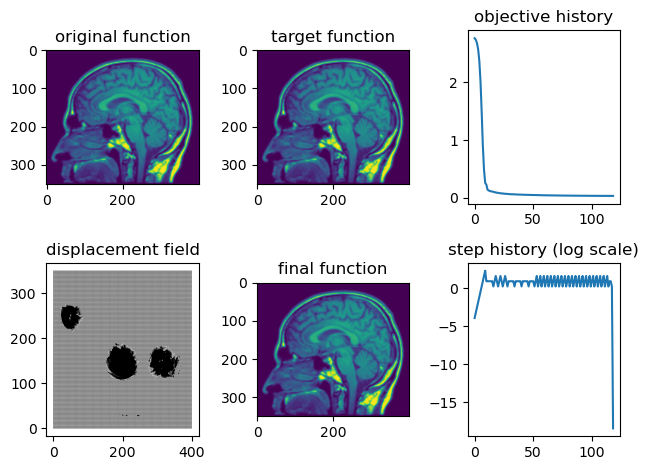

In [26]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

On choisit l'algorithme des moindres carrés afin de minimiser le nombre d'itérations. Dans le cas de l'algorithme de descente de gradient, cela peut prendre un temps assez conséquent afin d'assurer la convergence.
En choisissant des valeurs de lambda et de mu élevées (par exemple: $\lambda$=$\mu$=2), on remarque que même
avec l'algorithme des moindres carrés ( qui converge plus rapidement que celui de descente de gradient) , cela prend aussi un temps énorme ainsi qu'un nombre d'itérations assez conséquent avant d'assurer la convergence. C'est pour cela que j'ai décidé de choisir des valeurs $\lambda$=$\mu$=0.0001.
La valeur de $\sigma$ agit aussi sur la pertinence des résultats obtenus. En effet , pour $\sigma$=0.2, les deux images f et g sont presque identiques et on observe une tâche colorée et floue au niveau du crâne.Cela ne nous aide pas à determiner avec precision les endroits là où a lieu les changements.
Cependant, en réduisant la valeur de $\sigma$ à 0.01, on pourra distinguer les différences entre les deux images.
Cela est bel et bien représenté dans la figure 'displacement filed'. En effet les tâches en noir représentent les endroits où on a eu du changement (différences entre la fonction initiale et finale).